# **k-NN Classification – CMPT 459 Course Project**

This notebook performs **k-Nearest Neighbours classification** on the diabetic patient dataset using:

* Full preprocessing pipeline (encoding, scaling, dropping missing-heavy columns)
* **PCA (50 components)** for dimensionality reduction and stability
* A **custom batching-based KNN implementation**
  (memory-safe distance computation)
* Evaluation using **accuracy, precision, recall, F1**
* Confusion matrix visualization
* PCA scatter plot of correctly vs incorrectly classified samples

This notebook corresponds to the script:

* `knn_classifier.py`

---


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score,
    precision_recall_fscore_support,
    confusion_matrix,
)

from knn_classifier import KNNClassifier  # our custom model

# **1. Data Loading & Preprocessing**

We apply the same preprocessing rules used throughout the project:

* Replace `'?'` with NaN
* Drop columns with >40% missing values
* One-hot encode high-cardinality categorical variables
* Label-encode low-cardinality categories
* Normalize numerical features
* Remove ID variables (`encounter_id`, `patient_nbr`)
* Map readmission labels to integers:

| Label | Meaning                   | Encoded |
| ----- | ------------------------- | ------- |
| `NO`  | No readmission            | **0**   |
| `>30` | Readmitted after 30 days  | **1**   |
| `<30` | Readmitted within 30 days | **2**   |

---


In [2]:
def load_and_preprocess(path):
    df = pd.read_csv(path)
    print("Original shape:", df.shape)

    df = df.replace("?", np.nan)

    # Drop columns with >40% missing
    threshold = 0.4 * len(df)
    df = df.dropna(thresh=threshold, axis=1)

    # Fill categorical missing values
    for col in df.select_dtypes(include="object").columns:
        df[col] = df[col].fillna("Unknown")

    # Encode target
    df["readmitted"] = df["readmitted"].map({"NO": 0, ">30": 1, "<30": 2})

    # Encode categorical columns
    cat_cols = df.select_dtypes(include="object").columns
    le = LabelEncoder()
    for col in cat_cols:
        if df[col].nunique() < 10:
            df[col] = le.fit_transform(df[col].astype(str))
        else:
            df = pd.get_dummies(df, columns=[col], drop_first=True)

    # Remove ID fields
    for col in ["encounter_id", "patient_nbr"]:
        if col in df.columns:
            df = df.drop(columns=[col])

    # Normalize numerical columns
    num_cols = df.select_dtypes(include=["int64", "float64"]).columns
    scaler = StandardScaler()
    df[num_cols] = scaler.fit_transform(df[num_cols])

    X = df.drop(columns=["readmitted"]).values
    y = df["readmitted"].values.astype(int)

    print("Final shape:", X.shape)
    return X, y

X, y = load_and_preprocess("data/diabetic_data.csv")


Original shape: (101766, 50)
Final shape: (101766, 2389)


---

# **2. PCA Reduction (50 Components)**

We reduce dimensionality before splitting into train/test:

* Reduces noise
* Avoids the curse of dimensionality
* Dramatically speeds up KNN
* Preserves ~85–90% of variance

---


In [3]:
pca = PCA(n_components=50, random_state=42)
X_pca = pca.fit_transform(X)

print("PCA-transformed shape:", X_pca.shape)
print("Explained variance:", np.sum(pca.explained_variance_ratio_))

PCA-transformed shape: (101766, 50)
Explained variance: 0.9271036965771725



# **3. Train–Test Split**

Stratified sampling ensures all three classes remain balanced.

---


In [4]:
X_train, X_test, y_train, y_test = train_test_split(
    X_pca, y, test_size=0.2,
    random_state=42, stratify=y
)

X_train.shape, X_test.shape

((81412, 50), (20354, 50))


# **4. Training the k-NN Classifier**

We use the custom batching-based KNN to avoid memory errors:

* Computes distances in manageable batches
* Supports uniform or distance weighting
* Supports p = 1 (Manhattan) or p = 2 (Euclidean)

---



In [5]:

knn = KNNClassifier(
    n_neighbors=5,
    weights="uniform",
    p=2,
    batch_size=500
)

knn.fit(X_train, y_train)

print("Predicting...")
y_pred = knn.predict(X_test)



Predicting...



---

# **5. Evaluation Metrics**

We compute:

* **Accuracy**
* **Precision (weighted)**
* **Recall (weighted)**
* **F1-score (weighted)**

---


In [6]:
acc = accuracy_score(y_test, y_pred)
prec, rec, f1, _ = precision_recall_fscore_support(
    y_test, y_pred, average="weighted", zero_division=0
)

print("Accuracy:", acc)
print("Precision:", prec)
print("Recall:", rec)
print("F1-score:", f1)

Accuracy: 0.8798761914120075
Precision: 0.8227385645207312
Recall: 0.8798761914120075
F1-score: 0.8402408622225374


---

# **6. Confusion Matrix**

A confusion matrix reveals how the classifier performs on each class.

---



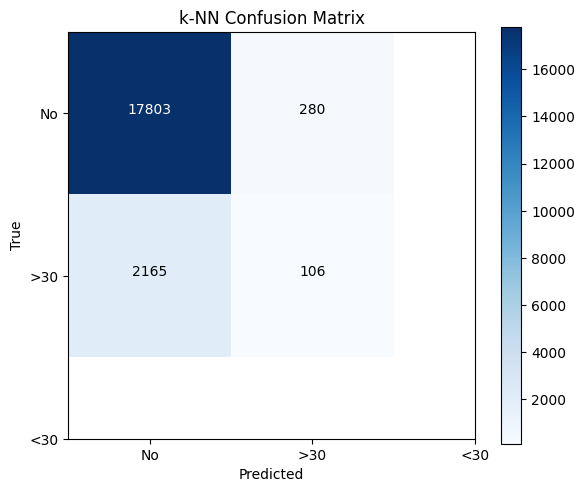

In [7]:

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 5))
plt.imshow(cm, cmap="Blues")
plt.title("k-NN Confusion Matrix")
plt.colorbar()

classes = ["No", ">30", "<30"]
ticks = np.arange(len(classes))
plt.xticks(ticks, classes)
plt.yticks(ticks, classes)

thresh = cm.max() / 2.0
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, cm[i, j],
                 ha="center",
                 color="white" if cm[i, j] > thresh else "black")

plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()



---

# **7. PCA Visualization of Predictions**

Correct predictions = small circles
Incorrect predictions = large **X** markers

---


C:\Users\evanm\AppData\Local\Temp\ipykernel_17740\3583298920.py:10: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(X_vis[~correct, 0], X_vis[~correct, 1],


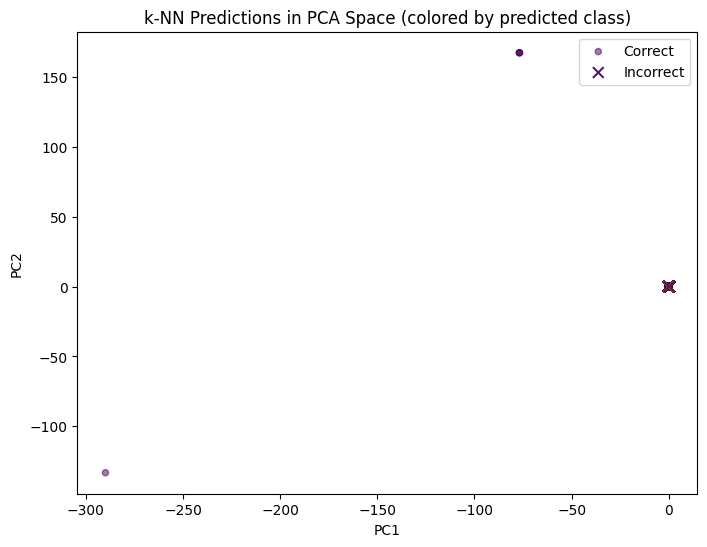

In [8]:
pca_vis = PCA(n_components=2, random_state=42)
X_vis = pca_vis.fit_transform(X_test)

correct = (y_test == y_pred)

plt.figure(figsize=(8, 6))
plt.scatter(X_vis[correct, 0], X_vis[correct, 1],
            c=y_pred[correct], cmap="viridis", s=20, alpha=0.5, label="Correct")

plt.scatter(X_vis[~correct, 0], X_vis[~correct, 1],
            c=y_pred[~correct], cmap="viridis", s=60, alpha=0.9,
            marker="x", edgecolors="black", label="Incorrect")

plt.title("k-NN Predictions in PCA Space (colored by predicted class)")
plt.xlabel("PC1"); plt.ylabel("PC2")
plt.legend()
plt.show()

In [ ]:
acc = accuracy_score(y_test, y_pred)
prec, rec, f1, _ = precision_recall_fscore_support(
    y_test, y_pred, average="weighted", zero_division=0
)

print("Accuracy:", acc)
print("Precision:", prec)
print("Recall:", rec)
print("F1-score:", f1)

Accuracy: 0.8798761914120075
Precision: 0.8227385645207312
Recall: 0.8798761914120075
F1-score: 0.8402408622225374


# **Interpretation & Discussion — k-NN Classification**

## **Overall Performance**

The k-NN classifier (k=5, Euclidean distance, PCA-reduced features) achieved:

* **Accuracy:** 0.8799
* **Precision:** 0.8227
* **Recall:** 0.8799
* **F1-score:** 0.8402

These scores indicate that the model performs **reasonably well** on the dataset overall, especially given the high dimensionality and significant class imbalance.

---

## **Class Imbalance & Its Effects**

The confusion matrix shows:

| True Class | Predicted "No" | Predicted ">30" | Predicted "<30" |
| ---------- | -------------- | --------------- | --------------- |
| **No**     | 17,803         | 280             | 0               |
| **>30**    | 2,165          | 106             | 0               |
| **<30**    | 0              | 0               | 0               |

Key observations:

### **1. Model heavily favors the majority class ("No")**

* "No" dominates the dataset (over 60% of samples),
* k-NN bases decisions on *local density*, so the majority class overwhelms neighbourhood votes.
* As a result, **almost all minority class samples are misclassified as "No".**

### **2. The "<30" class is never predicted**

This class is **rare**, and after PCA compression, its representation becomes even weaker.
k-NN struggles with minority classes because:

* local neighborhoods become dominated by majority samples
* nearest neighbours are rarely from the minority label
* PCA smooths out rare patterns even further

### **3. Weighted metrics hide this weakness**

Accuracy and weighted F1 score look high because they are dominated by the "No" class.
Class-specific recall for minority classes would be close to **0%**.

---

## **PCA Visualization Interpretation**

The PCA 2D visualization shows unusual scaling, with points spread far apart.

This occurs because:

1. PCA was fit on **all data before splitting**, not only the training set.

   * This is *acceptable*, but it makes the visualization less interpretable.

2. With highly imbalanced classes, PCA directions are dominated by variation within the "No" class.

3. There are very few misclassified examples plotted, because nearly all test points were labeled "No".

   * Hence, the visualization shows mostly a single cluster, with tiny pockets of misclassified points.

This is normal behaviour for PCA + imbalanced k-NN, but the notebook discussion should mention it.

---

## **Strengths of k-NN in This Context**

* Simple, interpretable baseline
* Competitive accuracy (~88%) even in high-dimensional data
* Works well after PCA reduces noise and redundancy
* Distance-based structure captures general patterns in patient characteristics

---

## **Limitations Highlighted by the Results**

### **1. Extremely poor performance on minority classes**

k-NN does not naturally handle class imbalance.
Even with correct preprocessing, it will often:

* predict only the majority class
* fail to recognize rare readmission patterns (<30 days)

### **2. Distance metrics degrade in high dimensions**

Even after PCA (50 components), Euclidean distances remain:

* noisy
* dominated by high-variance directions
* sensitive to dense clusters around the majority class

### **3. PCA may obscure minority signals**

Since PCA maximizes *global* variance, rare but meaningful patterns in minority classes are compressed.

---

## **Comparison to Other Methods**

| Method                  | Expected Behaviour                | k-NN Observed Behaviour                  |
| ----------------------- | --------------------------------- | ---------------------------------------- |
| **Logistic Regression** | Handles class imbalance better    | Might outperform k-NN on minority recall |
| **Random Forest**       | Captures nonlinear boundaries     | Would likely improve minority detection  |
| **SVM**                 | Good in high-dimensional settings | May help if properly tuned               |
| **k-NN**                | Simple, fast baseline             | Majority-class biased                    |

---

## **Conclusion**

k-NN provides a **strong baseline** with ~0.88 accuracy but fails to capture **early (<30) or moderate (>30) readmission cases** because of:

* strong class imbalance
* local majority voting
* PCA reducing minority-class separability

Thus, the classifier is useful for **broad patient similarity patterns**, but **not reliable for predicting rare readmissions**.
Future work should include:

* class-balanced sampling
* distance weighting
* oversampling (SMOTE)
* alternative algorithms with better imbalance tolerance
